In [1]:
#!/usr/bin/env python3
from std_srvs.srv import Empty, Trigger, TriggerRequest
import smach
from move_base_msgs.msg import MoveBaseAction, MoveBaseGoal
from geometry_msgs.msg import PoseStamped, Point , Quaternion, Twist
from actionlib_msgs.msg import GoalStatus
import moveit_commander
import moveit_msgs.msg
import tf2_ros
from tf2_sensor_msgs.tf2_sensor_msgs import do_transform_cloud
import controller_manager_msgs.srv
import rospy
import trajectory_msgs.msg
import geometry_msgs.msg
#from object_classification.srv import *
from sensor_msgs.msg import Image as ImageMsg
from cv_bridge import CvBridge, CvBridgeError

import cv2 as cv
import numpy as np

from utils_notebooks import *
from utils_takeshi import *

In [2]:
global lis, broad, tf_static_broad, tfbuff,scene, rgbd, gripper, head, whole_body
global arm, goal, navclient, clear_octo_client, service_client, base_vel_pub, starter, stopper

moveit_commander.roscpp_initialize(sys.argv)
rospy.init_node('Grab_cassette')
head = moveit_commander.MoveGroupCommander('head')
gripper = moveit_commander.MoveGroupCommander('gripper')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
arm =  moveit_commander.MoveGroupCommander('arm')
    
tfbuff = tf2_ros.Buffer()
lis = tf2_ros.TransformListener(tfbuff)
broad = tf2_ros.TransformBroadcaster()
tf_static_broad = tf2_ros.StaticTransformBroadcaster()
whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0]) 
    
scene = moveit_commander.PlanningSceneInterface()
robot = moveit_commander.RobotCommander()
rgbd = RGBD()
hand_cam = HandRGB()
goal = MoveBaseGoal()
    
navclient = actionlib.SimpleActionClient('/move_base/move', MoveBaseAction)
clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)
service_client = rospy.ServiceProxy('/segment_2_tf', Trigger)
base_vel_pub = rospy.Publisher('/hsrb/command_velocity', Twist, queue_size=10)
starter = rospy.ServiceProxy('/marker/start_recognition',Empty)
stopper = rospy.ServiceProxy('/marker/stop_recognition',Empty)
# hand_cam = rospy.
   

[ WARN] [1663014874.818669619]: Link hand_l_finger_vacuum_frame has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1663014874.821442690]: Link head_l_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1663014874.821512389]: Link head_r_stereo_camera_link has visual geometry but no collision geometry. Collision geometry will be left empty. Fix your URDF file by explicitly specifying collision geometry.
[ WARN] [1663014874.822269053]: Group state 'neutral' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1663014874.822302319]: Group state 'go' doesn't specify all group joints in group 'arm'. wrist_ft_sensor_frame_joint is missing.
[ WARN] [1663014888.045274642]: Kinematics solver doesn't support #attempts any

In [3]:
import rospy
from sensor_msgs.msg import Image as ImageMsg
# from cv_bridge import CvBridge
# bridge = CvBridge()
class HandRGB():
    def __init__(self):
        self._cloud_sub = rospy.Subscriber(
            '/hsrb/hand_camera/image_raw',
            ImageMsg, self._callback)
        self._points_data = None
        self._image_data = None
        
    def _callback(self, msg):
        
#         self._points_data = ros_numpy.numpify(msg)
        self._image_data = ros_numpy.numpify(msg)
#         cv_image = bridge.imgmsg_to_cv2(image_message, desired_encoding='passthrough')
        
    def get_image(self):
        image = self._image_data
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        return image

In [4]:
hand_cam = HandRGB()

In [15]:
def color_segmentator(plot = False):
    image = hand_cam.get_image()
# print(image)
# image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    img_hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    umbral_bajo = (102,95,97)
    umbral_alto = (115,255,255)
# hacemos la mask y filtramos en la original
    mask = cv2.inRange(img_hsv, umbral_bajo, umbral_alto)
    res = cv2.bitwise_and(img_hsv, img_hsv, mask=mask)
    if plot:
        plt.subplot(1, 2, 1)
        plt.imshow(mask, cmap='gray')
        plt.subplot(1, 2, 2)
        plt.imshow(res)
        plt.show()
    pos = []
    pixels = cv.findNonZero(mask)
#     print([pixels])
    pixels = list(cv.mean(pixels))
    pos.append(pixels[:2])
    return pos
# print(get_line(mask))
#opening = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
#closing = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
# cv2.imwrite('hand_img.jpg', image)
# cv2.imshow("image", image)

In [16]:
# valores del centroide con la altura de Pre_grasp
pos = [[258.61,261.75]]
# valores del centroide con la altura necesaria
pos = [[233.80,268.74]]
color_segmentator()

[[203.15973515414856, 177.40295882474652]]

In [19]:
THRESHOLD = 15
while(True):
    goalPos = [258.61,261.75]
    [currentPos] = color_segmentator()
#     print(currentPos)
    ex = -(goalPos[0]-currentPos[0]) 
    ey = (goalPos[1]-currentPos[1])
    print(ex, ey)
    if abs(ex) > THRESHOLD:
        tiny_move_base(x = ex, std_time=0.1, MAX_VEL=0.01)#, y = -traf.y + Y_OFFSET)
        rospy.sleep(0.5)
    if abs(ey) > THRESHOLD:
        tiny_move_base(y = ey, std_time=0.1, MAX_VEL=0.01)
        rospy.sleep(0.5)
    if (abs(ex) <= THRESHOLD and abs(ey) <= THRESHOLD):
        print('done')
        break

acp = arm.get_current_joint_values()
acp[0] = 0.56
arm.set_joint_value_target(acp)
arm.go()

6.274229157636171 -51.526874729085364
5.586169979938006 -54.37693780776948
1.6522550804865546 -26.52194260324859
-5.082838561591416 23.256394141436203
-11.362502212841292 58.65457547490976
-8.292356544823377 53.48500782792186
-4.1041180677226805 15.936076447241362
3.0015958545532158 -28.26271412799599
9.057527178853206 -66.28090571937611
7.616333493512741 -60.53148449340188
-2.4328185098258928 -4.977957403580092
done


True

In [164]:
acp = arm.get_current_joint_values()
print(acp)

[0.5497683790598138, -1.3375525280188854, 9.365465630573055e-05, -1.827492630284966, 0.025775108223816012, 0.0]


In [116]:
def apertura(frame, kernel):
    frame = cv.erode(frame, kernel)
    frame = cv.dilate(frame, kernel)
    return frame
def cerradura(frame, kernel):
    frame = cv.dilate(frame, kernel)
    frame = cv.erode(frame, kernel)
    return frame
def colorSegmenter (frame, color):
    frame = cv.cvtColor(frame, cv.COLOR_RGB2HSV)
    if color == 'blue':
        lower_limit = np.array([100,90,80])
        upper_limit = np.array([130,255,255])
    elif color == 'red':
        lower_limit = np.array([150,130,160])
        upper_limit = np.array([190,255,255])
    elif color == 'orange':
        lower_limit = np.array([82,94,97])
        upper_limit = np.array([115,255,255])
#         lower_limit = (82,94,97)
#         upper_limit = (115,255,255)
#         lower_limit = (23,100,82)
#         upper_limit = (50,100,255)
    else:
        print("Set DEFAULT as Blue")
        lower_limit = np.array([100,90,100])
        upper_limit = np.array((115,255,255))
    frame = cv.inRange(frame, lower_limit, upper_limit)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (10,10))
    frame = cerradura(frame, kernel)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (15,15))
    frame = apertura(frame, kernel)
    return frame
def sticks_detection(frame):
    pos = []
    red = colorSegmenter(frame, 'blue')
    plt.imshow(red)
    pixels = cv.findNonZero(red)
    pixels = list(cv.mean(pixels))
    pos.append(pixels[:2])
    return red, pos

In [125]:
get_line('hand')

TypeError: 'NoneType' object is not iterable

[[378.4745834961458, 116.45515257006855]]


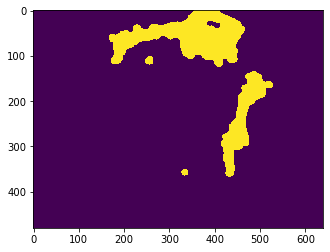

In [94]:
_, pos =sticks_detection(hand_cam.get_image())
print(pos)

In [10]:
def gaze_point(x,y,z):
    head_pose = head.get_current_joint_values()
#     head_pose[0]=0.0
#     head_pose[1]=0.0
#     head.set_joint_value_target(head_pose)
#     head.go()
    t = tfbuff.lookup_transform('base_link', 'head_rgbd_sensor_gazebo_frame', rospy.Time(0)) #
    trans ,rot = tf2_obj_2_arr(t) 
    e = tf.transformations.euler_from_quaternion(rot)
    x_rob,y_rob,z_rob,th_rob= trans[0], trans[1] ,trans[2] ,  e[2]
    D_x=x_rob-x
    D_y=y_rob-y
    D_z=z_rob-z
    D_th= np.arctan2(D_y,D_x)
    print('relative to robot',(D_x,D_y,np.rad2deg(D_th)))
    pan_correct= (- th_rob + D_th + np.pi) % (2*np.pi)
    if(pan_correct > np.pi):
        pan_correct=-2*np.pi+pan_correct
    if(pan_correct < -np.pi):
        pan_correct=2*np.pi+pan_correct
    if ((pan_correct) > .5 * np.pi):
        print ('Exorcist alert')
        pan_correct=.5*np.pi
    head_pose[0]=pan_correct
    tilt_correct=np.arctan2(D_z,np.linalg.norm((D_x,D_y)))
    head_pose [1]=-tilt_correct    
    head.set_joint_value_target(head_pose)
    succ=head.go()
    return succ

def get_line(camera):
    if camera == 'hand':
         img = hand_cam.get_image()
    elif camera == 'head':
        img = rgbd.get_image()
#     cv.imwrite('table.jpg',img)
#     img = cv.imread(cv.samples.findFile('table.jpg'))
#     gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    edges = cv.Canny(gray, 50, 150, apertureSize = 3)
    lines = cv.HoughLines(edges, 1, np.pi/180,200)
#     if len(lines)
    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
#         if theta > 0.707 and theta < 2 and (y1 or y2)>480/2:
#             cv.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
#     cv.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)    
#     cv.imwrite('TableLines.jpg',img)
    return lines

def tf2_obj_2_arr(transf):
    trans = []
    trans.append(transf.transform.translation.x)
    trans.append(transf.transform.translation.y)
    trans.append(transf.transform.translation.z)
    
    rot = []
    rot.append(transf.transform.rotation.x)
    rot.append(transf.transform.rotation.y)
    rot.append(transf.transform.rotation.z)
    rot.append(transf.transform.rotation.w)
    
    return [trans, rot]
    
    
def correct_points(low_plane=.0,high_plane=0.2):

    #Corrects point clouds "perspective" i.e. Reference frame head is changed to reference frame map
    data = rospy.wait_for_message('/hsrb/head_rgbd_sensor/depth_registered/rectified_points', PointCloud2)
    np_data = ros_numpy.numpify(data)
    
#   new implementation to use only tf2
    transf = tfbuff.lookup_transform('map', 'head_rgbd_sensor_gazebo_frame', rospy.Time())
    [trans, rot] = tf2_obj_2_arr(transf)
    
    eu = np.asarray(tf.transformations.euler_from_quaternion(rot))
    t = TransformStamped()
    rot = tf.transformations.quaternion_from_euler(-eu[1], 0, 0)
    t.header.stamp = data.header.stamp
    
    t.transform.rotation.x = rot[0]
    t.transform.rotation.y = rot[1]
    t.transform.rotation.z = rot[2]
    t.transform.rotation.w = rot[3]

    cloud_out = do_transform_cloud(data, t)
    np_corrected = ros_numpy.numpify(cloud_out)
    corrected = np_corrected.reshape(np_data.shape)

    img = np.copy(corrected['y'])

    img[np.isnan(img)] = 2
    #img3 = np.where((img>low)&(img< 0.99*(trans[2])),img,255)
    img3 = np.where((img>0.99*(trans[2])-high_plane)&(img< 0.99*(trans[2])-low_plane),img,255)
    return img3

def plane_seg_square_imgs(lower=500, higher=50000, reg_ly= 30, reg_hy=600, plt_images=True, low_plane=.0, high_plane=0.2):

    #Segment  Plane using corrected point cloud
    #Lower, higher = min, max area of the box
    #reg_ly= 30,reg_hy=600    Region (low y  region high y ) Only centroids within region are accepted
    
    image = rgbd.get_h_image()
    iimmg = rgbd.get_image()
    points_data = rgbd.get_points()
    img = np.copy(image)
    img3 = correct_points(low_plane,high_plane)
    
#     cv2 on python 3
    contours, hierarchy = cv2.findContours(img3.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            img = cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                image_aux = iimmg[boundRect[1]:boundRect[1]+max(boundRect[2],boundRect[3]),boundRect[0]:boundRect[0]+max(boundRect[2],boundRect[3])]
                images.append(image_aux)
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, f'centroid_{i}_{cX},{cY}',    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                #print ('cX,cY',cX,cY)
                xyz = []

                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux = (np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz = np.asarray(xyz)
                cent = xyz.mean(axis=0)
                cents.append(cent)
#                 print (cent)
                points.append(xyz)
#             else:
#                 print ('cent out of region... rejected')
    sub_plt = 0
    if plt_images:
        for image in images:
           
            sub_plt += 1
            ax = plt.subplot(5, 5, sub_plt)
          
            plt.imshow(image)
            plt.axis("off")

    cents=np.asarray(cents)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points), images)

def seg_square_imgs(lower=2000, higher=50000, reg_ly=0, reg_hy=1000, reg_lx=0, reg_hx=1000, plt_images=True): 

#     Using kmeans for image segmentation find
#     Lower, higher = min, max area of the box
#     reg_ly= 30,reg_hy=600,reg_lx=0,reg_hx=1000, 
#     Region (low  x,y  region high x,y ) Only centroids within region are accepted
    image = rgbd.get_h_image()
    iimmg = rgbd.get_image()
    points_data = rgbd.get_points()
    values = image.reshape((-1,3))
    values = np.float32(values)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k = 6
    _ , labels , cc = cv2.kmeans(values, k, None, criteria, 30, cv2.KMEANS_RANDOM_CENTERS)
    cc = np.uint8(cc)
    segmented_image = cc[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    kernel = np.ones((5, 5), np.uint8)
    im4 = cv2.erode(th3, kernel, iterations = 4)
    plane_mask = points_data['z']
    cv2_img = plane_mask.astype('uint8')
    img = im4
    contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i = 0
    cents = []
    points = []
    images = []
    for i, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            image_aux = iimmg[boundRect[1]:boundRect[1] + max(boundRect[3],boundRect[2]),boundRect[0]:boundRect[0]+max(boundRect[3],boundRect[2])]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            #img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+max(boundRect[2],boundRect[3]), boundRect[1]+max(boundRect[2],boundRect[3])), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy and  cX > reg_lx and cX < reg_hx   ):
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, f'centroid_{i}_{cX},{cY}', (cX - 25, cY - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                #print ('cX,cY',cX,cY)
                xyz = []
                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)
                xyz = np.asarray(xyz)
                cent = xyz.mean(axis=0)
                cents.append(cent)
                #print (cent)
                points.append(xyz)
            else:
                #print ('cent out of region... rejected')
                images.pop()
    sub_plt = 0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )
            plt.imshow(image)
            plt.axis("off")
    cents=np.asarray(cents)
    #images.append(img)
    return(cents,np.asarray(points), images)

def __manipulate_gripper(pos = 0.5, vel = 0.5, effort = 0.2):
    grip_cmd_pub = rospy.Publisher('/hsrb/gripper_controller/command',
                               trajectory_msgs.msg.JointTrajectory, queue_size=100)
    traj = trajectory_msgs.msg.JointTrajectory()
    traj.joint_names = ["hand_motor_joint"]
    p = trajectory_msgs.msg.JointTrajectoryPoint()
    p.positions = [pos]
    p.velocities = [vel]
    p.accelerations = []
    p.effort = [effort]
    p.time_from_start = rospy.Duration(1)
    traj.points = [p]

    grip_cmd_pub.publish(traj)

def open_gripper(eff=0.5):
    __manipulate_gripper(pos=1.23, vel=0.5, effort=eff)
    
def close_gripper(eff=0.5):
    __manipulate_gripper(pos=-0.831, vel=-0.5, effort=-eff)

def static_tf_publish(cents):
#     Publish tfs of the centroids obtained w.r.t. head sensor frame and references them to map (static)
    transf = tfbuff.lookup_transform('map', 'base_link', rospy.Time(0))
    [trans, rot] = tf2_obj_2_arr(transf)
#     closest_centroid_index=  np.argmin(np.linalg.norm(trans-cents, axis=1))##CLOSEST CENTROID
    closest_centroid_index = 0
    min_D_to_base = 10
    for  i, cent  in enumerate(cents):
        x, y, z = cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan')
        else:
            t = geometry_msgs.msg.TransformStamped()
            t.header.stamp = rospy.Time.now()
            t.header.frame_id = "head_rgbd_sensor_link"
            t.child_frame_id = f'Object{i}'
            t.transform.translation.x = x
            t.transform.translation.y = y
            t.transform.translation.z = z
            t.transform.rotation.x = rot[0]
            t.transform.rotation.y = rot[1]
            t.transform.rotation.z = rot[2]
            t.transform.rotation.w = rot[3]
            broad.sendTransform(t)
#             broad.sendTransform((x,y,z), rot, rospy.Time.now(), 'Object'+str(i), "head_rgbd_sensor_link")
            rospy.sleep(0.5)
            transf = tfbuff.lookup_transform('map', f'Object{i}', rospy.Time(0))
            [xyz_map, cent_quat] = tf2_obj_2_arr(transf)
            D_to_base = np.linalg.norm(np.asarray(trans)[:2] - np.asarray(xyz_map)[:2])
            if D_to_base <= min_D_to_base:
                min_D_to_base = D_to_base
                closest_centroid_index = i
                closest_centroid_height = xyz_map[2]
            print ('Distance: base to obj - ', i, np.linalg.norm(np.asarray(trans)[:2] - np.asarray(xyz_map)[:2]))
    i = closest_centroid_index
    transf = tfbuff.lookup_transform('map', f'Object{i}', rospy.Time(0))
    [xyz_map, cent_quat] = tf2_obj_2_arr(transf)
    print('Height closest centroid map', xyz_map[2])
    map_euler = tf.transformations.euler_from_quaternion(cent_quat)
    rospy.sleep(.5)
#     FIXING TF TO MAP ( ODOM REALLY)    
    static_ts = TransformStamped()
    static_ts.header.stamp = rospy.Time.now()
    static_ts.header.frame_id = "map"
    static_ts.child_frame_id = 'cassette'
    static_ts.transform.translation.x = float(xyz_map[0])
    static_ts.transform.translation.y = float(xyz_map[1])
    static_ts.transform.translation.z = float(xyz_map[2])
#     quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
    static_ts.transform.rotation.x = 0#-quat[0]#trans.transform.rotation.x
    static_ts.transform.rotation.y = 0#-quat[1]#trans.transform.rotation.y
    static_ts.transform.rotation.z = 0#-quat[2]#trans.transform.rotation.z
    static_ts.transform.rotation.w = 1#-quat[3]#trans.transform.rotation.w
    print ('xyz_map', xyz_map)
    tf_static_broad.sendTransform(static_ts)
    return closest_centroid_height, closest_centroid_index

def static_publish_ARmarker():
    transf = tfbuff.lookup_transform('map', 'ar_marker/201', rospy.Time(0))
    [xyz_map, cent_quat] = tf2_obj_2_arr(transf)
    print('Height closest centroid map', xyz_map[2])
    map_euler = tf.transformations.euler_from_quaternion(cent_quat)
    rospy.sleep(.5)
#     FIXING TF TO MAP ( ODOM REALLY)    
    static_ts = TransformStamped()
    static_ts.header.stamp = rospy.Time.now()
    static_ts.header.frame_id = "map"
    static_ts.child_frame_id = 'cassette'
    static_ts.transform.translation.x = float(xyz_map[0])
    static_ts.transform.translation.y = float(xyz_map[1])
    static_ts.transform.translation.z = float(xyz_map[2])
#     quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
    static_ts.transform.rotation.x = 0#-quat[0]#trans.transform.rotation.x
    static_ts.transform.rotation.y = 0#-quat[1]#trans.transform.rotation.y
    static_ts.transform.rotation.z = 0#-quat[2]#trans.transform.rotation.z
    static_ts.transform.rotation.w = 1#-quat[3]#trans.transform.rotation.w
    print ('xyz_map', xyz_map)
    tf_static_broad.sendTransform(static_ts)

def tiny_move_base(x = 0, y = 0, theta = 0, std_time = 0.5, MAX_VEL = 0.03):
    MAX_VEL = 0.03
    velX = x/std_time
    velY = y/std_time
    time = std_time
    if abs(velX) > MAX_VEL or abs(velY) > MAX_VEL:
        newVelX =  MAX_VEL * np.sign(velX)
        newVelY = MAX_VEL * np.sign(velY)
#         timeX = x / MAX_VEL
#         timeY = y / MAX_VEL
#         if timeX > timeY:
#             time = timeX
#         else:
#             time = timeY
    else :
        newVelX = velX
        newVelY = velY
    move_base(newVelX, newVelY, theta/std_time, time)

def move_base_vel(vx, vy, vw):
    twist = Twist()
    twist.linear.x = vx
    twist.linear.y = vy
    twist.angular.z = vw 
    base_vel_pub.publish(twist)

def move_base(x,y,yaw,timeout=0.2):
    start_time = rospy.Time.now().to_sec()
    while rospy.Time.now().to_sec() - start_time < timeout:  
        move_base_vel(x, y, yaw)
        
def table_alignment():
    hcp = head.get_current_joint_values()
    hcp[0] = 0.0
    hcp[1] = -0.5
    head.set_joint_value_target(hcp)
    head.go()
    threshold = 0.05
    while True:
        lin = get_line('head')
        suma = 0
        for el in lin:
            suma += el[0][1]
        prom = suma / len(lin)
        e = 1.5707 - prom
        print(e)
        if abs(e) < threshold:
            break
        else:    
            move_base(0.0,0.0,0.7*e,0.2)

In [6]:
hcp = head.get_current_joint_values()
# print(hcp)
hcp[0]=0.4
hcp[1]= -0.2
head.set_joint_value_target(hcp)
head.go()
succ = False
last = 0
while not succ:
    
    try:
#         t = tfbuff.lookup_transform('base_link', 'ar_marker/201', rospy.Time(0) )
#         traf = tf2_obj_2_arr(t)
#         print(traf)
#         if traf
        t = tfbuff.lookup_transform('base_link', 'ar_marker/201', rospy.Time(0) )
        rospy.sleep(0.3)
#         print(t)
        trans, _ = tf2_obj_2_arr(t)
        print(trans[0])
        
        new = trans[0]
        if(last== new):
            hcp = head.get_current_joint_values()
            hcp[0] += 0.1
            hcp[1]= -0.2
            head.set_joint_value_target(hcp)
            head.go()
        if trans[0] < 0.45:
            succ = True
        else:
            tiny_move_base(x=0.5,std_time=0.1)
#         break
        last = new
    except:
        tiny_move_base(x=0.5,std_time=0.1)

0.8981473305925011
0.8981473305925011
0.8439076535531004
0.8439076535531004
0.8127221770996045
0.8127221770996045
0.7820685690173658
0.7811812009025797
0.7811812009025797
0.7426763911840679
0.7396952937533766
0.7346831211038647
0.7320274307602063
0.7117652284158097
0.7042466883187842
0.6938315513283753
0.6788366103931502
0.6698881005816136
0.6593290236489737
0.6503558080441494
0.6324291676164715
0.6198804727992431
0.6119424414665153
0.6119424414665153
0.5387536655613594
0.548299331493654
0.5439273833698891
0.5289374139914238
0.5247045703954498
0.5107026205343945
0.49377264506502244
0.47744958906055246
0.4674541855264047
0.45988172221161816
0.4403664659302242


In [11]:
table_alignment()

0.13953000135421756
0.13953000135421756
0.13953000135421756
0.13953000135421756
0.13953000135421756
0.13953000135421756
0.13953000135421756
0.13953000135421756
0.13953000135421756
0.13953000135421756
0.13953000135421756
0.13953000135421756
0.2675208154042561
0.2675208154042561
0.2675208154042561
0.2675208154042561
0.2675208154042561
0.2675208154042561
0.2675208154042561
0.2675208154042561
0.2675208154042561
0.06971690085728954
0.06971690085728954
0.06971690085728954
0.06971690085728954
0.06971690085728954
0.06971690085728954
0.06971690085728954
0.06971690085728954
0.06971690085728954
0.06971690085728954
0.06971690085728954
0.06971690085728954
0.20934317536354063
0.20934317536354063
0.20934317536354063
0.20934317536354063
0.20934317536354063
0.20934317536354063
0.20934317536354063
0.20934317536354063
0.20934317536354063
0.20934317536354063
0.20934317536354063
0.03674952547285293


In [5]:
# arm.set_named_target('neutral')

# arm.go()
hcp = head.get_current_joint_values()
hcp[0] = -0.1
hcp[1] = -0.5
head.set_joint_value_target(hcp)
head.go()
# start_AR_recognition()
# starter = rospy.ServiceProxy('/marker/start_recognition',Empty)
# stopper = rospy.ServiceProxy('/marker/stop_recognition', Empty)

True

In [4]:
starter.call()
# static_publish_ARmarker()

[[-0.12267153  0.413494    1.1211635 ]
 [-0.10409301  0.31896338  1.2245353 ]
 [-0.575319    0.33617282  1.1287789 ]
 [-1.0722715  -0.97066474  3.063259  ]]


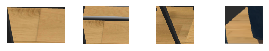

[ WARN] [1661539857.577818147, 230.766000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 230.784000 according to authority /pose_integrator
[ WARN] [1661539857.578063668, 230.766000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 230.784000 according to authority unknown_publisher
[ WARN] [1661539864.196925861, 232.002000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 232.026000 according to authority /pose_integrator
[ WARN] [1661539864.200189622, 232.002000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 232.026000 according to authority unknown_publisher
[ WARN] [1661539864.774273744, 232.128000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 232.227000 according to authority unknown_publisher
[ WARN] [1661539864.779747023, 232.128000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame

[ WARN] [1661539980.361936090, 252.246000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 252.288000 according to authority unknown_publisher
[ WARN] [1661539980.363259660, 252.246000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 252.288000 according to authority /pose_integrator
[ WARN] [1661539988.046171832, 253.950000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 253.989000 according to authority /pose_integrator
[ WARN] [1661539988.047416990, 253.950000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 253.989000 according to authority unknown_publisher
[ WARN] [1661539988.656922233, 254.046000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 254.112000 according to authority unknown_publisher
[ WARN] [1661539988.657654747, 254.046000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame

[ WARN] [1661540106.356728982, 274.746000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 274.785000 according to authority unknown_publisher
[ WARN] [1661540106.358084764, 274.746000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 274.785000 according to authority /pose_integrator
[ WARN] [1661540111.359904547, 275.589000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 275.616000 according to authority /pose_integrator
[ WARN] [1661540111.361483919, 275.589000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 275.616000 according to authority unknown_publisher
[ WARN] [1661540130.327886225, 278.850000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 278.850000 according to authority /pose_integrator
[ WARN] [1661540130.347794117, 278.850000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame 

[ WARN] [1661540282.757965271, 305.754000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 305.754000 according to authority /pose_integrator
[ WARN] [1661540282.759377055, 305.754000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 305.754000 according to authority unknown_publisher
[ WARN] [1661540288.678249746, 306.810000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 306.846000 according to authority /pose_integrator
[ WARN] [1661540288.682255046, 306.810000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 306.846000 according to authority unknown_publisher
[ WARN] [1661540312.141483067, 310.707000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 310.731000 according to authority /pose_integrator
[ WARN] [1661540312.143230207, 310.707000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame 

[ WARN] [1661540408.950075100, 326.766000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 326.808000 according to authority unknown_publisher
[ WARN] [1661540408.950204971, 326.766000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 326.808000 according to authority /pose_integrator
[ WARN] [1661540414.070570810, 327.726000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 327.780000 according to authority /pose_integrator
[ WARN] [1661540414.070811246, 327.726000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 327.780000 according to authority unknown_publisher
[ WARN] [1661540415.718333390, 328.020000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 328.113000 according to authority unknown_publisher
[ WARN] [1661540415.718750410, 328.020000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame

[ WARN] [1661540431.099456094, 330.777000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 330.768000 according to authority unknown_publisher
[ WARN] [1661540431.100651275, 330.777000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 330.768000 according to authority /pose_integrator
[ WARN] [1661540433.376458974, 331.095000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 331.209000 according to authority /pose_integrator
[ WARN] [1661540433.380301240, 331.095000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 331.209000 according to authority unknown_publisher
[ WARN] [1661540436.496090448, 331.662000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 331.683000 according to authority unknown_publisher
[ WARN] [1661540436.497282254, 331.662000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame

[ WARN] [1661540446.377084040, 333.465000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 333.495000 according to authority unknown_publisher
[ WARN] [1661540446.391830640, 333.465000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 333.495000 according to authority /pose_integrator
[ WARN] [1661540447.329434369, 333.648000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 333.705000 according to authority /pose_integrator
[ WARN] [1661540447.329658673, 333.648000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 333.705000 according to authority unknown_publisher
[ WARN] [1661540450.484127727, 334.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 334.149000 according to authority /pose_integrator
[ WARN] [1661540450.490304526, 334.101000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame 

In [10]:
# arm.get_current_joint_values()
# close_gripper(1)
# open_gripper(0.5)
cents, xyz, images = plane_seg_square_imgs(lower=500, higher= 9000,low_plane=0.0,high_plane=0.7)
print(cents)

In [19]:
tiny_move_base(0.0,0.0,0.2)

In [9]:
table_alignment()

-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
-0.3666154640197754
0.15174730844497675
0.15174730844497675
0.15174730844497675
0.15174730844497675
0.15174730844497675
0.15174730844497675
0.15174730844497675
0.15174730844497675
0.15174730844497675
0.15174730844497675
0.15174730844497675
0.15174730844497675
0.15174730844497675
0.15174730844497675


In [13]:
tiny_move_base(0.0,0,0.3)

In [96]:
arm.get_current_joint_values()

[0.5949133911802521,
 -1.3379355280188854,
 0.002143654656305838,
 -1.8275136302849657,
 -0.15370289177618401,
 0.0]

In [78]:
static_tf_publish(cents)

Distance: base to obj -  0 3.3875782538926447
Distance: base to obj -  1 0.645859329239056
Distance: base to obj -  2 0.8204264992657743
Distance: base to obj -  3 0.6494874487469856
Height closest centroid map 0.6426071673636605
xyz_map [-0.8850686327347419, -0.25151301974417994, 0.6426071673636605]


(0.6426071673636605, 1)

In [12]:
grasp_from_above_joints=[0.59,-1.3376,0,-1.8275,0.0,0.0]
arm.set_joint_value_target(grasp_from_above_joints)
arm.go()

True

In [53]:
tiny_move_base(y = 0.163)

In [13]:
X_OFFSET = 0.0
Y_OFFSET = 0.19
Z_OFFSET = 0.135

# X_OFFSET = 0.0
# Y_OFFSET = 0.0
# Z_OFFSET = 0.135
THRESHOLD = 0.025
# THRESHOLD_y = 0.015
hcp = head.get_current_joint_values()
hcp[0] = -0.1
hcp[1] = -0.5
head.set_joint_value_target(hcp)
head.go()
while(True):
    try:
        t = tfbuff.lookup_transform('hand_palm_link', 'ar_marker/201', rospy.Time(0) )
#         t = tfbuff.lookup_transform('hand_palm_link', 'ar_marker/4000', rospy.Time(0) )
        traf = t.transform.translation
        rospy.sleep(.6)
        # tiny_move_base(y = 0.163)
        ex = x = traf.x + X_OFFSET
        ey = -traf.y + Y_OFFSET
        print(ex, ey)
        if abs(ex) > THRESHOLD:
            tiny_move_base(x = ex)#, y = -traf.y + Y_OFFSET)
        if abs(ey) > THRESHOLD:
            tiny_move_base(y = ey)
        if (abs(ex) <= THRESHOLD and abs(ey) <= THRESHOLD):
            hcp[0] = 0
            head.set_joint_value_target(hcp)
            head.go()
            break
    except:
        hcp = head.get_current_joint_values()
        hcp[0] -= 0.1   
        print(hcp[0])
        head.set_joint_value_target(hcp)
        head.go()
        if hcp[0] < -1:
            hcp[0] = 0.1
            head.set_joint_value_target(hcp)
            head.go()
            print('Ive lost the reference')
            break

0.18206044985683112 -0.07963676197958103
0.18077576898262848 -0.08204285837805414
0.16376267821065316 -0.05799227993958983
0.14912171320579481 -0.029690443332722694
0.1297656616285232 -0.006464209257546261
0.11706898613260186 0.011072387461636468
0.09961603066927394 0.025464086583341705
0.06165537424209311 0.03123962812630171
0.042112388788395294 0.004777305724930236
0.029347725306565264 -0.009126465317773003
0.019078794314005942 -0.02641238450546396
-0.01923277895010389 -0.02557613299206324
-0.035685880512142276 -0.026318878588169448
-0.035685880512142276 -0.026318878588169448
-0.032739539748185775 0.02910410571583938
-0.01566133829922778 0.03699763488155755
-0.01566133829922778 0.03699763488155755
0.0012475152873097084 0.017285147550490765


In [16]:
hand_cam.get_image()

array([[[16, 16, 16],
        [16, 16, 16],
        [11, 18, 14],
        ...,
        [20, 15, 18],
        [16, 15, 18],
        [16, 15, 18]],

       [[18, 16, 16],
        [18, 16, 16],
        [16, 16, 16],
        ...,
        [20, 15, 18],
        [13, 16, 18],
        [13, 16, 18]],

       [[16, 16, 16],
        [16, 16, 16],
        [13, 17, 16],
        ...,
        [20, 15, 18],
        [16, 15, 18],
        [16, 15, 18]],

       ...,

       [[16, 16, 16],
        [16, 16, 16],
        [16, 16, 16],
        ...,
        [20, 17, 13],
        [20, 16, 16],
        [20, 16, 16]],

       [[16, 16, 16],
        [16, 16, 16],
        [16, 16, 16],
        ...,
        [20, 16, 16],
        [16, 16, 16],
        [16, 16, 16]],

       [[16, 16, 16],
        [16, 16, 16],
        [16, 16, 16],
        ...,
        [20, 17, 13],
        [16, 16, 16],
        [16, 16, 16]]], dtype=uint8)

In [117]:
tr = tfbuff.lookup_transform('head_l_stereo_camera_frame', 'ar_marker/201', rospy.Time(0))
print(tr)

header: 
  seq: 0
  stamp: 
    secs: 1662408747
    nsecs: 123095036
  frame_id: "head_l_stereo_camera_frame"
child_frame_id: "ar_marker/201"
transform: 
  translation: 
    x: -0.14347501605042673
    y: 0.15732225270132918
    z: 0.5154270624021277
  rotation: 
    x: -0.3222956746461686
    y: -0.1456418210249864
    z: -0.2527666914397325
    w: 0.9005681305551001


In [95]:
tiny_move_base(x=-ex)
# tiny_move_base(y = -ey)
print(ex,ey)

-0.18241688078796336 -0.03828563605475077


[WARN] [1661454076.973070]: Inbound TCP/IP connection failed: connection from sender terminated before handshake header received. 0 bytes were received. Please check sender for additional details.


In [45]:
acp = arm.get_current_joint_values()
acp[0]-= 0.01
arm.set_pose_target(acp)
arm.go()

False

In [24]:
transf = tfbuff.lookup_transform('map', 'cassette', rospy.Time(0))
trans,_= tf2_obj_2_arr(transf)

transf2 = tfbuff.lookup_transform('map', 'hand_palm_link', rospy.Time(0))
trans2,_ = tf2_obj_2_arr(transf2)

e = trans2[1]-trans[1]
wb_cp = whole_body.get_current_pose()
wb_cp.pose.position.y += e
whole_body.set_pose_target(wb_cp)
whole_body.go()

print(e)

0.008520200142226764


In [13]:
arm.set_named_target('neutral')
arm.go()

True

In [19]:
armCV=arm.get_current_joint_values()
armCV[4]=0
arm.set_joint_value_target(armCV)
arm.go()

True

In [ ]:
arm.set_joint_value_target([0.5,-0.3,0.0,-1.57,0.0,0.0])
arm.go()

In [5]:
trans = tfbuff.lookup_transform("base_link", "hand_palm_link", rospy.Time(0))
# print(trans)
x = trans.transform.translation.x
y = trans.transform.translation.y
z = trans.transform.translation.z
print(x,y,z)

0.4729522031074358 0.07799611449982691 0.8820346202499413


[ WARN] [1660862664.576825583, 66.678000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 66.711000 according to authority /pose_integrator
[ WARN] [1660862664.578804568, 66.678000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 66.711000 according to authority unknown_publisher
[ WARN] [1660862665.967811586, 67.014000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 67.050000 according to authority /pose_integrator
[ WARN] [1660862665.968031980, 67.014000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 67.050000 according to authority unknown_publisher
[ WARN] [1660862668.998937162, 67.524000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 67.566000 according to authority unknown_publisher
[ WARN] [1660862669.001234977, 67.524000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at ti

[ WARN] [1660862917.108565461, 105.288000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 105.321000 according to authority unknown_publisher
[ WARN] [1660862917.108682777, 105.288000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 105.321000 according to authority /pose_integrator
[ WARN] [1660862943.315340627, 108.678000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 108.702000 according to authority /pose_integrator
[ WARN] [1660862943.315994081, 108.678000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 108.702000 according to authority unknown_publisher
[ WARN] [1660862948.901388920, 109.584000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame arm_flex_link at time 109.710000 according to authority unknown_publisher
[ WARN] [1660862948.901493287, 109.584000000]: TF_REPEATED_DATA ignoring data with redundant timestamp 

[ WARN] [1660862960.622965268, 111.597000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 111.639000 according to authority unknown_publisher
[ WARN] [1660862960.623134206, 111.597000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 111.639000 according to authority /pose_integrator
[ WARN] [1660862961.750475476, 111.816000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 111.840000 according to authority /pose_integrator
[ WARN] [1660862961.752295171, 111.816000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 111.840000 according to authority unknown_publisher
[ WARN] [1660862973.640210204, 113.655000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 113.682000 according to authority /pose_integrator
[ WARN] [1660862973.641987529, 113.655000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame 

[ WARN] [1660863206.917094301, 149.727000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 149.760000 according to authority unknown_publisher
[ WARN] [1660863206.917797156, 149.727000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 149.760000 according to authority /pose_integrator
[ WARN] [1660863207.923341060, 149.844000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 149.892000 according to authority /pose_integrator
[ WARN] [1660863207.924433485, 149.844000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 149.892000 according to authority unknown_publisher
[ WARN] [1660863222.482512445, 151.803000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 151.842000 according to authority unknown_publisher
[ WARN] [1660863222.483214170, 151.803000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame

[ WARN] [1660863449.745626716, 185.802000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 185.862000 according to authority unknown_publisher
[ WARN] [1660863449.751274743, 185.802000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 185.862000 according to authority /pose_integrator
[ WARN] [1660863453.015648956, 186.237000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 186.297000 according to authority /pose_integrator
[ WARN] [1660863453.016002412, 186.237000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 186.297000 according to authority unknown_publisher
[ WARN] [1660863455.274454904, 186.768000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 186.804000 according to authority /pose_integrator
[ WARN] [1660863455.275133811, 186.768000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame 

[ WARN] [1660863469.119587861, 189.027000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 189.171000 according to authority unknown_publisher
[ WARN] [1660863469.123155388, 189.027000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 189.171000 according to authority /pose_integrator
[ WARN] [1660863469.942944838, 189.246000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 189.276000 according to authority /pose_integrator
[ WARN] [1660863469.945318512, 189.246000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 189.276000 according to authority unknown_publisher
[ WARN] [1660863481.973960903, 191.292000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 191.334000 according to authority /pose_integrator
[ WARN] [1660863481.975180553, 191.292000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame 

[ WARN] [1660863700.030283854, 225.411000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 225.435000 according to authority unknown_publisher
[ WARN] [1660863700.030383236, 225.411000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 225.435000 according to authority /pose_integrator
[ WARN] [1660863703.880612051, 226.017000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 226.056000 according to authority /pose_integrator
[ WARN] [1660863703.881158588, 226.017000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 226.056000 according to authority unknown_publisher
[ WARN] [1660863722.763666003, 228.879000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 228.924000 according to authority /pose_integrator
[ WARN] [1660863722.764264437, 228.879000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame 

[ WARN] [1660863934.889700419, 261.339000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 261.369000 according to authority /pose_integrator
[ WARN] [1660863934.890568567, 261.339000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 261.369000 according to authority unknown_publisher
[ WARN] [1660863989.426165450, 269.244000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 269.298000 according to authority /pose_integrator
[ WARN] [1660863989.426589105, 269.244000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 269.298000 according to authority unknown_publisher
[ WARN] [1660863996.415815533, 270.342000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame odom at time 270.366000 according to authority /pose_integrator
[ WARN] [1660863996.416366544, 270.342000000]: TF_REPEATED_DATA ignoring data with redundant timestamp for frame 